# Bayesian Stats

This notebook can be used to conduct bayesian ttests and ANOVAS with pymc

In [62]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.stats import gaussian_kde, norm
import ipywidgets as widgets
from IPython.display import display, clear_output

print("Running with PyMC version:", pm.__version__)


Running with PyMC version: 5.22.0


In [63]:
# paths 
# here we have paths to folders where the logging histories of individual training runs are stored.

# for Unet and Swin Transformer models trained on MACS, we have two sets of logs:
unet_macs_loss_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ae_samples'
swin_macs_loss_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ae_samples'

# for Unet and Swin Transformer models trained on PS, we have two sets of logs:
unet_ps_loss_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ps_samples'
swin_ps_loss_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ps_samples'

# these are the metrics that we want to analyse plus the ones where higher is better.
metrics = ['loss', 'specificity', 'sensitivity', 'IoU', 'f1_score', 'Hausdorff_distance']
maximize_metrics = {'specificity', 'sensitivity', 'IoU', 'f1_score'}

# and some output directories where we will save the results of our analysis.
unet_macs_output_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ae_samples'
swin_macs_output_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ae_samples'

## Read and plot the data

In [64]:
# this function reads the metrics from CSV files in a given directory and returns them as a 3D numpy array, with
# the shape (number of files, number of epochs, number of metrics). It also returns a lookup dictionary for metric names

def read_metrics_as_array(directory, metrics):
    
    """
    Reads CSV files from a directory and extracts specified metrics into a 3D numpy array.
    Args:
        directory (str): Path to the directory containing CSV files.
        metrics (list): List of metric names to extract from the CSV files.
    Returns:
        tuple: A tuple containing:
            - data_array (np.ndarray): A 3D numpy array of shape (num_files, num_epochs, num_metrics).
            - lookup (dict): A dictionary mapping metric names to their indices in the data array.
            - files (list): List of file names processed.
    """

    files = sorted([f for f in os.listdir(directory) if f.endswith('.csv')])
    data_list = []
    
    metric_names = []
    for metric in metrics:
        metric_names.append(metric)
        metric_names.append('val_' + metric)

    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        file_data = []

        for name in metric_names:
            if name in df.columns:
                file_data.append(df[name].values)
            else:
                # Fill with NaNs if column is missing
                file_data.append(np.full(len(df), np.nan))
        
        # Transpose so shape is (epochs, metrics)
        file_data = np.stack(file_data, axis=1)  # shape: (epochs, num_metrics)
        data_list.append(file_data)

    # Convert to a 3D array: (files, epochs, metrics)
    data_array = np.stack(data_list, axis=0)

    # Build lookup dict
    lookup = {name: idx for idx, name in enumerate(metric_names)}

    return data_array, lookup, files


In [65]:
# this function plots the val and train metric from the array of losses.

def plot_losses(loss_array, metrics, metric_lookup, output_dir, show_plot=False):
    """
    Plots training and validation metrics from a 3D numpy array of losses.
    Args:
        loss_array (np.ndarray): 3D numpy array of shape (num_files, num_epochs, num_metrics).
        metrics (list): List of metric names to plot.
        metric_lookup (dict): Dictionary mapping metric names to their indices in the loss_array.
        output_dir (str): Directory to save the plot.
        show_plot (bool): Whether to display the plot interactively.
    """

    epochs = loss_array.shape[1]
    num_metrics = len(metrics)

    plt.figure(figsize=(20, 2.5))  # Square layout
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, num_metrics, i + 1)

        # Training metric
        for j in range(loss_array.shape[0]):
            plt.plot(range(epochs), loss_array[j, :, metric_lookup[metric]], color='lightblue', linewidth=1)

        train_mean = np.nanmean(loss_array[:, :, metric_lookup[metric]], axis=0)
        
        # Validation metric
        val_metric = 'val_' + metric
        if val_metric in metric_lookup:
            for j in range(loss_array.shape[0]):
                plt.plot(range(epochs), loss_array[j, :, metric_lookup[val_metric]], color='peachpuff', linewidth=1)

            val_mean = np.nanmean(loss_array[:, :, metric_lookup[val_metric]], axis=0)
            plt.plot(range(epochs), train_mean, color='tab:blue', label=f'train', linewidth=2)
            plt.plot(range(epochs), val_mean, color='tab:orange', label=f'val', linewidth=2)

        plt.title(metric)
        plt.ylim(0,1)
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        #plt.legend(loc='upper right')
        plt.grid(True)
        plt.gca().set_aspect('auto')  # Square plot per metric (approx)
    
    plt.tight_layout()
    output_path = os.path.join(output_dir, 'losses_plot.png')
    plt.savefig(output_path)
    if show_plot:
        plt.show()
    plt.close()
    print(f"Plot saved to {output_path}")

(10, 150, 12)

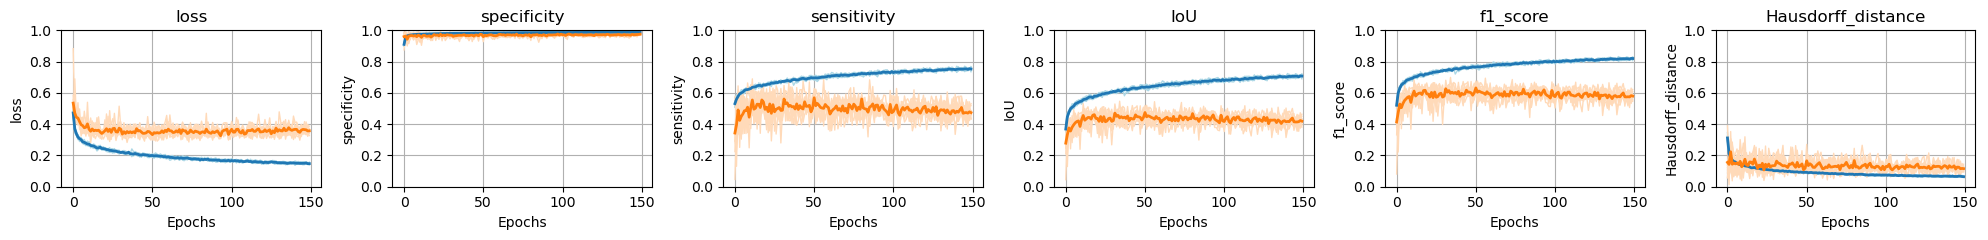

Plot saved to N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ae_samples\losses_plot.png


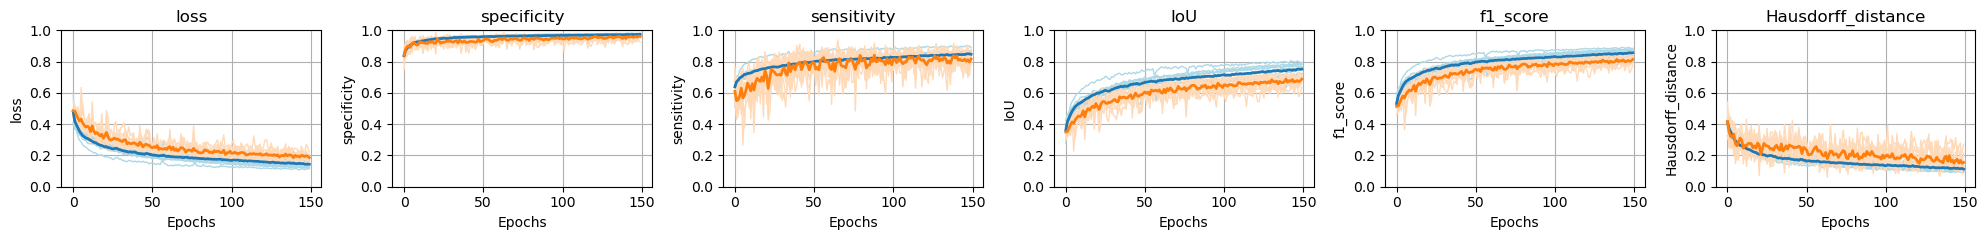

Plot saved to N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ae_samples\losses_plot.png


C:\Users\castad001\AppData\Local\Temp\ipykernel_18752\854613799.py:26: RuntimeWarning: Mean of empty slice
  train_mean = np.nanmean(loss_array[:, :, metric_lookup[metric]], axis=0)


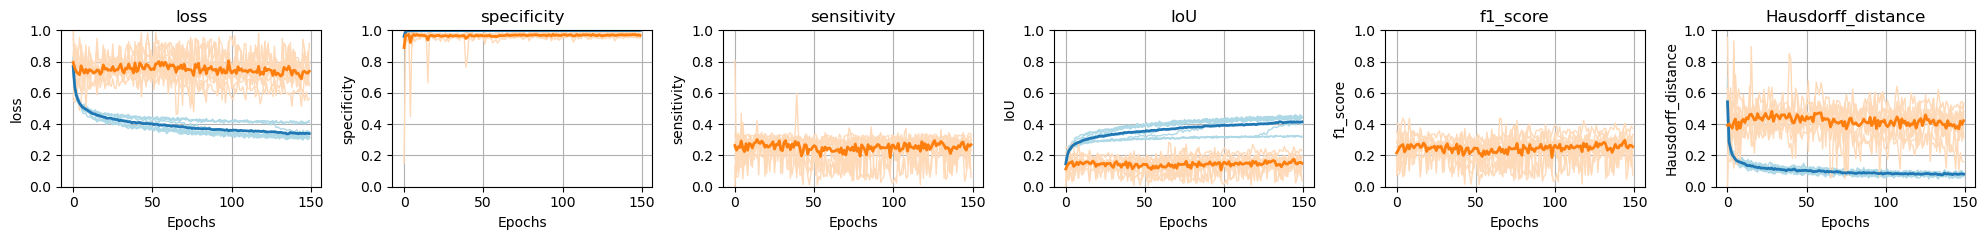

Plot saved to N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ps_samples\losses_plot.png


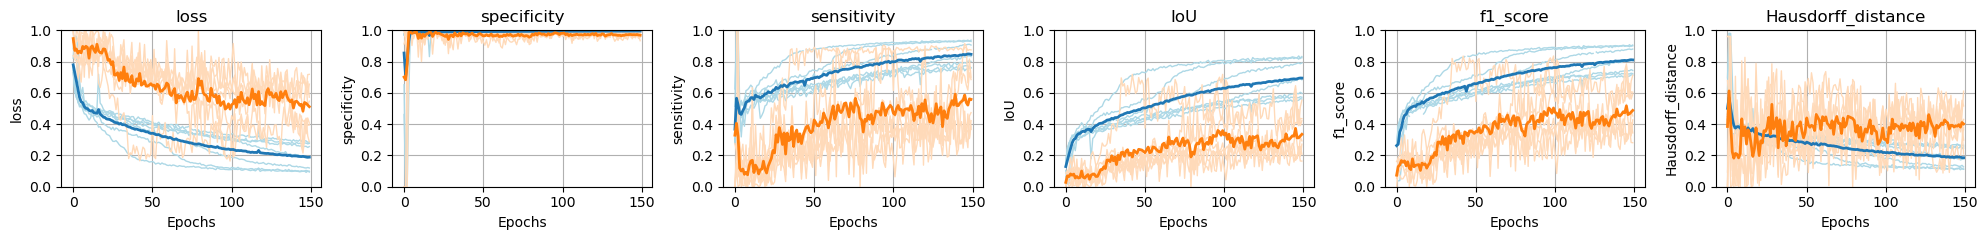

Plot saved to N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ps_samples\losses_plot.png


In [66]:
# lets import and plot the losses for Unet and Swin Transformer models trained on MACS and PS datasets.

unet_macs, unet_macs_metric_lookup, unet_macs_file_names = read_metrics_as_array(unet_macs_loss_dir, metrics)
swin_macs, swin_macs_metric_lookup, swin_macs_file_names = read_metrics_as_array(swin_macs_loss_dir, metrics)
unet_ps, unet_ps_metric_lookup, unet_ps_file_names = read_metrics_as_array(unet_ps_loss_dir, metrics)
swin_ps, swin_ps_metric_lookup, swin_ps_file_names = read_metrics_as_array(swin_ps_loss_dir, metrics)
display(swin_macs.shape)

plot_losses(unet_macs, metrics, unet_macs_metric_lookup, unet_macs_output_dir, show_plot=True)
plot_losses(swin_macs, metrics, swin_macs_metric_lookup, swin_macs_output_dir, show_plot=True)
plot_losses(unet_ps, metrics, unet_ps_metric_lookup, unet_ps_loss_dir, show_plot=True)
plot_losses(swin_ps, metrics, swin_ps_metric_lookup, swin_ps_loss_dir, show_plot=True)

In [39]:
# next we will define a function to get the metric values across epochs at the point of the lowest val_loss for each file in the data array.
# we also define a function to help interpret the Bayes factor values.

def get_best_metric(data_array, metric_lookup, metric):
    """
    Get the best metric values across epochs for each file in the data array.
    Args:
        data_array (np.ndarray): 3D array of shape (files, epochs, metrics).
        metric_lookup (dict): Dictionary mapping metric names to their indices.
        metric (str): The metric to evaluate.
        maximize_metrics (set): Set of metrics that should be maximized.
    Returns:
        np.ndarray: Array of best metric values for each file.
    """

    best_values = []


    for i in range(data_array.shape[0]):

        losses = data_array[i, :, metric_lookup['loss']]
        values = data_array[i, :, metric_lookup[metric]]


        best_epoch = np.nanargmin(losses)
        #print(f'best epoch; {best_epoch}')

        best_value = values[best_epoch]
        #print('best value:', best_value)

        best_values.append(best_value)

    return np.array(best_values)

def interpret_bayes_factor(bf):
    """Return Jeffreys-style verbal label for a Bayes factor > 1."""
    if bf < 3:
        return "anecdotal"
    elif bf < 10:
        return "moderate"
    elif bf < 30:
        return "strong"
    elif bf < 100:
        return "very strong"
    else:
        return "extreme"

## BEST Bayesian T-test

The **BEST (Bayesian Estimation Supersedes the t-Test)** approach offers a modern, more informative alternative to the traditional **t-test**. While the t-test provides a p-value to assess whether two group means are significantly different, it relies heavily on assumptions like:

- Normality of data
- Equal variances
- A fixed significance threshold (e.g., *p* < 0.05)

Moreover, the t-test doesn't convey the size or uncertainty of the effect in an intuitive way.

In contrast, **BEST** uses Bayesian methods to estimate the full **posterior distribution** of the group means and their difference. This approach provides a richer understanding, including:

- How large the difference might be
- How uncertain we are about that difference
- The probability that one group is greater than the other

BEST is also more robust to common issues like unequal variances and outliers.

In short, **BEST supersedes the t-test** by delivering **more nuanced, probabilistic insights** into group comparisons, rather than a single binary decision.

In [40]:
def BEST(combined_array, group_one, group_two, metric, group_one_label='unet', group_two_label='swin', plot=True):

    """
    Perform Bayesian estimation of the difference in means and standard deviations
    between two groups using Student's t-distribution (Kruschke 2005).
    Args:
        combined_array (pd.DataFrame): DataFrame containing the metric values and group labels.
        group_one (np.ndarray): values of group 1.
        group_two (np.ndarray): values of group 2.
    Returns:
        None
    """
    minimal_metrcis = ['val_loss', 'loss', 'val_Hausdorff_distance', 'Hausdorff_distance']

    metric_values = combined_array[metric].values

    mu_m = metric_values.mean()
    mu_s = metric_values.std()*2

    sigma_low = 10**-1
    sigma_high = 10

    # define the model. change the priors as needed. 

    with pm.Model() as model:

        # Priors for group means (share common hyperpriors mu_m, mu_s)
        # We place Normal priors on each group’s mean, centered at a common location (mu_m) with shared uncertainty (mu_s) comming from the data (weakly informed).
        group1_mean = pm.Normal(f'{group_one_label}_mean', mu=mu_m, sigma=mu_s)
        group2_mean = pm.Normal(f'{group_two_label}_mean', mu=mu_m, sigma=mu_s)

        # Priors for group standard deviations (allowing unequal variances)
        # Each group’s scale is given an independent Uniform prior between sigma_low and sigma_high, allowing heterogeneity (previously defined --> uninformend as not from the data).
        group1_std = pm.Uniform(f'{group_one_label}_std', lower=sigma_low, upper=sigma_high)
        group2_std = pm.Uniform(f'{group_two_label}_std', lower=sigma_low, upper=sigma_high)

        # Degrees of freedom for Student-t (robust to outliers)
        #To model heavy tails and robustness to outliers, we use a Student-t likelihood. We put an Exponential prior on nu − 1, shift it to nu, and also expose its log₁₀ for diagnostics.
        nu_minus_one = pm.Exponential('nu_minus_one', lam=1/29)
        nu = pm.Deterministic('nu', nu_minus_one + 1)
        nu_log10 = pm.Deterministic('nu_log10', np.log10(nu))

        # Convert std to precision for the Student-t likelihood
        # Student-t in PyMC uses precision (λ = σ⁻²), so we square-invert the std priors.
        lambda_group1 = group1_std**-2
        lambda_group2 = group2_std**-2

        # Observation models for each group
        # Each group’s data are modeled as Student-t draws with their own mean, precision, and shared ν.
        group_one_obs = pm.StudentT(f'{group_one_label}_obs', mu=group1_mean, lam=lambda_group1, nu=nu, observed=group_one)
        group_two_obs = pm.StudentT(f'{group_two_label}_obs', mu=group2_mean, lam=lambda_group2, nu=nu, observed=group_two)

        # Deterministic comparisons for interpretation
        # We compute the difference of means, difference of stds, and Cohen’s d–style effect size for easy interpretation of the posterior.
        diff_of_means = pm.Deterministic('diff_of_means', group1_mean - group2_mean)
        diff_of_stds = pm.Deterministic('diff_of_stds', group1_std - group2_std)
        effect_size = pm.Deterministic('effect_size', diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

        # Posterior sampling
        idata = pm.sample(tune=1000, draws=2000, chains=4, target_accept=0.95, return_inferencedata=True)

    if plot:

        

        # Plotting the posterior distributions and summaries
        print('\n---- Posterior for the means and stds ----')

        az.plot_posterior(idata, var_names=[f'{group_one_label}_mean', f'{group_two_label}_mean', f'{group_one_label}_std', f'{group_two_label}_std', 'nu_log10', 'nu'])
        plt.show()

        print('\n---- Posterior for the differences and effect size ----')

        az.plot_posterior(idata, var_names=['diff_of_means', 'diff_of_stds', 'effect_size'], ref_val=0)
        plt.show()

        print('\n---- Forests for means, stds, and nu ----')
        
        az.plot_forest(idata, var_names=[f'{group_one_label}_mean', f'{group_two_label}_mean'])
        plt.show()

        print('\n---- Forests for stds and nu ----')

        az.plot_forest(idata, var_names=[f'{group_one_label}_std', f'{group_two_label}_std', 'nu'])
        plt.show()

    print('\n---- Model summary ----')

    summary = az.summary(idata, var_names=[f'{group_one_label}_mean', f'{group_two_label}_mean','diff_of_means', 'diff_of_stds', 'effect_size'])
    print(summary)

    print('\n---- Savage-Dickey Bayes Factor ----\n')

    
    # Posterior density at δ = 0  (KDE is still appropriate here)
    diff_samples = idata.posterior['diff_of_means'].values.flatten()
    posterior_kde            = gaussian_kde(diff_samples)
    posterior_density_at_zero = posterior_kde.evaluate(0)[0]

    # Analytical prior density at δ = 0  (δ ~ Normal(0, √2·mu_s))
    prior_sd_diff            = np.sqrt(2) * mu_s
    prior_density_at_zero    = norm.pdf(0, loc=0, scale=prior_sd_diff)

    # Bayes factors
    BF_01 = posterior_density_at_zero / prior_density_at_zero   # H₀ over H₁
    BF_10 = 1 / BF_01                                           # H₁ over H₀

    metric_is_lower_better = metric  in minimal_metrcis
    mean_diff = diff_samples.mean()   # μ_unet − μ_swin

    if BF_10 > 1:            # data support the alternative
        # who wins, given the metric direction?
        if (not metric_is_lower_better and mean_diff > 0) or \
        (    metric_is_lower_better and mean_diff < 0):
            winner, loser = group_one_label, group_two_label
        else:
            winner, loser = group_two_label, group_one_label

        label = interpret_bayes_factor(BF_10)
        print(f"p(δ=0)        : {prior_density_at_zero:.4g}")
        print(f"p(δ=0 | data) : {posterior_density_at_zero:.4g}")
        print(f"Evidence for {winner} outperforming {loser}: "
            f"BF₁₀ = {BF_10:.4g}  ({label})\n")

    else:                     # data support the null
        label = interpret_bayes_factor(BF_01)
        print(f"p(δ=0)        : {prior_density_at_zero:.4g}")
        print(f"p(δ=0 | data) : {posterior_density_at_zero:.4g}")
        print(f"Evidence for no difference (H₀): "
            f"BF₀₁ = {BF_01:.4g}  ({label})")

In [41]:
# we call the BEST function to compare Unet and Swin Transformer models trained on MACS and PS datasets and visualise them as tabs

tabs     = []      # the Output widgets (one per metric)
tab_titles = []    # used to label the tab headers

for metric in metrics:

    full_metric = 'val_' + metric if not metric.startswith('val_') else metric
    out = widgets.Output()          # each metric gets its own Output “sandbox”

    with out:                       # everything inside goes only to this tab
        clear_output(wait=True)     # keeps the tab clean on reruns

        print(f"### Processing metric: {full_metric}\n")

        unet_macs_best = get_best_metric(unet_macs, unet_macs_metric_lookup, full_metric)
        swin_macs_best = get_best_metric(swin_macs, swin_macs_metric_lookup, full_metric)

        #plt.boxplot([unet_best, swin_best], labels=['UNet', 'Swin Transformer'], showfliers=True)



        BEST(
            pd.concat([
                pd.DataFrame({full_metric: unet_macs_best, 'group': 'U-Net | Aerial'}),
                pd.DataFrame({full_metric: swin_macs_best, 'group': 'Swin U-Net | Aerial'}),
            ]).reset_index(drop=True),
            unet_macs_best, swin_macs_best, full_metric,
            plot=True                                    
        )

    # keep references so we can build the Tab afterwards
    tabs.append(out)
    tab_titles.append(full_metric)

tab_widget = widgets.Tab(children=tabs)

for i, title in enumerate(tab_titles):
    tab_widget.set_title(i, title)   # label each tab

display(tab_widget)


## Bayesian ANOVA

**Bayesian ANOVA** offers a more flexible and informative alternative to the traditional **frequentist ANOVA**. While classical ANOVA tests whether there are any statistically significant differences between group means, it comes with several limitations:

- It provides only a *p-value*, not the size or uncertainty of effects.
- It assumes normality, homogeneity of variance, and fixed effects.
- It gives no direct probability for hypotheses—just whether the null is rejected or not.

In contrast, **Bayesian ANOVA** uses probability distributions to directly model uncertainty and effect sizes. Instead of asking whether group means are different *in general*, it estimates:

- The **posterior distribution** of each group mean
- The **probability** of differences between groups
- The **credible intervals** that reflect uncertainty in estimates

Bayesian ANOVA can also naturally handle more complex models (e.g., hierarchical structures, unequal variances) and allows for **model comparison using Bayes Factors**, offering a principled way to weigh evidence for competing hypotheses.

In short, **Bayesian ANOVA** goes beyond just testing for significance—it provides a **deeper, probabilistic understanding** of group differences, effect sizes, and model credibility.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import ipywidgets as widgets
from IPython.display import display, clear_output

print("PyMC:", pm.__version__, "| ArviZ:", az.__version__)

# Jeffreys‐style labels ------------------------------------------------------ #
def interpret_bayes_factor(bf):
    if bf < 3:
        return "anecdotal"
    elif bf < 10:
        return "moderate"
    elif bf < 30:
        return "strong"
    elif bf < 100:
        return "very strong"
    else:
        return "extreme"

# --------------------------------------------------------------------------- #
# Bayesian models                                                             #
# --------------------------------------------------------------------------- #
def fit_bayesian_anova(df, metric, lower_is_better=False,
                       robust=True, hierarchical=True,
                       tune=1000, draws=2000, chains=4, target_accept=0.95):
    """
    One-way Bayesian ANOVA that *also* stores prior predictive draws so we can
    call az.bayes_factor() on deterministic contrasts (Savage–Dickey).
    """
    y = df[metric].values
    groups = df["group"].astype("category")
    g_idx = groups.cat.codes.values
    names = groups.cat.categories.tolist()
    K = len(names)

    mu_m, mu_s = y.mean(), y.std() * 2
    sigma_low, sigma_high = 1e-1, 10

    with pm.Model() as model:
        # -- group means ----------------------------------------------------
        if hierarchical:
            mu_grand = pm.Normal("mu_grand", mu=mu_m, sigma=mu_s)
            tau = pm.HalfNormal("tau", sigma=mu_s)
            mu = pm.Normal("mu", mu=mu_grand, sigma=tau, shape=K)
        else:
            mu = pm.Normal("mu", mu=mu_m, sigma=mu_s, shape=K)

        # -- group stds -----------------------------------------------------
        sigma = pm.Uniform("sigma", lower=sigma_low, upper=sigma_high, shape=K)

        # -- likelihood -----------------------------------------------------
        if robust:
            nu = pm.Exponential("nu_minus_1", 1/29) + 1
            pm.StudentT("obs", mu=mu[g_idx], sigma=sigma[g_idx], nu=nu, observed=y)
        else:
            pm.Normal("obs", mu=mu[g_idx], sigma=sigma[g_idx], observed=y)

        # -- deterministic contrast (first two groups) ---------------------
        if K >= 2:
            pm.Deterministic("diff_of_means", mu[0] - mu[1])
        else:
            raise ValueError("Need ≥2 groups to compute diff_of_means")

        # -- posterior ------------------------------------------------------
        idata = pm.sample(tune=tune, draws=draws, chains=chains,
                          target_accept=target_accept,
                          return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})

        # -- prior predictive ----------------------------------------------
        prior_idata = pm.sample_prior_predictive(4000, return_inferencedata=True)

    idata.extend(prior_idata)              # append prior → needed for BF
    idata.attrs.update(metric=metric,
                       lower_is_better=lower_is_better,
                       groups=names)
    return idata


def fit_bayesian_null(df, metric, robust=True,
                      tune=1000, draws=2000, chains=4, target_accept=0.95):
    """Null model with one common mean (only for LOO/WAIC BF)."""
    y = df[metric].values
    mu_m, mu_s = y.mean(), y.std()*2
    sigma_low, sigma_high = 1e-1, 10

    with pm.Model():
        mu = pm.Normal("mu", mu=mu_m, sigma=mu_s)
        sigma = pm.Uniform("sigma", lower=sigma_low, upper=sigma_high)
        if robust:
            nu = pm.Exponential("nu_minus_1", 1/29) + 1
            pm.StudentT("obs", mu=mu, sigma=sigma, nu=nu, observed=y)
        else:
            pm.Normal("obs", mu=mu, sigma=sigma, observed=y)

        idata_null = pm.sample(tune=tune, draws=draws, chains=chains,
                               target_accept=target_accept,
                               return_inferencedata=True,
                               idata_kwargs={"log_likelihood": True})
    return idata_null


def loo_bayes_factor(idata_alt, idata_null):
    """BF10 ≈ exp(Δ elpd / 2) using LOO (fallback WAIC)."""
    try:
        delta = az.loo(idata_alt).elpd_loo - az.loo(idata_null).elpd_loo
    except Exception:
        delta = az.waic(idata_alt).elpd_waic - az.waic(idata_null).elpd_waic
    return np.exp(delta / 2)


# Posterior helpers ---------------------------------------------------------- #
def prob_each_is_best(idata):
    best = idata.posterior["mu"].stack(s=("chain","draw")).values
    lower = idata.attrs["lower_is_better"]
    idx = best.argmin(0) if lower else best.argmax(0)
    return pd.Series(np.bincount(idx, minlength=best.shape[0]) / idx.size,
                     index=idata.attrs["groups"], name="p(best)")


def pairwise_contrasts(idata, rope=None):
    means = idata.posterior["mu"].stack(s=("chain","draw")).values
    names = idata.attrs["groups"]
    rows = []
    for i in range(len(names)-1):
        for j in range(i+1, len(names)):
            diff = means[i] - means[j]
            rows.append(dict(A=names[i], B=names[j],
                             mean_diff=diff.mean(),
                             hdi_low=np.quantile(diff, .025),
                             hdi_high=np.quantile(diff, .975),
                             p_A_gt_B=(diff>0).mean(),
                             p_in_rope=((rope[0]<diff)&(diff<rope[1])).mean() if rope else np.nan))
    return pd.DataFrame(rows)

PyMC: 5.22.0 | ArviZ: 0.21.0


In [48]:
# We build one tab per metric to explore group performance and run our ANOVA.
# --------------------------------------------------------------------------- #
# ❶ DATA SOURCES                                                              #
# --------------------------------------------------------------------------- #
group_data = {
    "U-Net | Aerial":        (unet_macs,          unet_macs_metric_lookup),
    "U-Net | PS":            (unet_ps,            unet_ps_metric_lookup),
    "Swin U-Net | Aerial":   (swin_macs,          swin_macs_metric_lookup),
    "Swin U-Net | PS":       (swin_ps,            swin_ps_metric_lookup),
    # add more groups as needed
}

# Metrics where lower values are better (e.g. losses, distances)
minimal_metrics = {"val_loss", "loss", "val_Hausdorff_distance", "Hausdorff_distance"}


# --------------------------------------------------------------------------- #
# ❷ HELPERS                                                                   #
# --------------------------------------------------------------------------- #
def best_per_group(metric_name):
    """Return dict {group: best-per-run values array} for a metric."""
    out = {}
    for name, (arr, lookup) in group_data.items():
        out[name] = get_best_metric(arr, lookup, metric_name)     # ← defined elsewhere
    return out


# ---------- Bayes-factor helpers ------------------------------------------- #
def bf_group_is_best(idata, group_name):
    """
    Savage–Dickey Bayes factor that *group_name* is the best group
    (highest mean unless lower_is_better is True).
    """
    names  = idata.attrs["groups"]
    idx    = names.index(group_name)
    lower  = idata.attrs["lower_is_better"]

    def _is_best(ds):
        mu   = ds["mu"].values                 # (chain, draw, K)
        best = mu.min(axis=-1) if lower else mu.max(axis=-1)
        return (mu[..., idx] == best)

    post_prob  = _is_best(idata.posterior).mean()
    prior_prob = _is_best(idata.prior).mean()
    bf10 = post_prob / prior_prob
    return dict(BF10=bf10, BF01=1/bf10,
                post_prob=post_prob, prior_prob=prior_prob)


def bf_pairwise(idata, A, B, rope=None):
    """
    Bayes factor that μ[A] − μ[B] is > 0 (directional) *or*
    outside a ROPE interval (lo, hi) if rope is not None.
    """
    names = idata.attrs["groups"]
    a, b  = names.index(A), names.index(B)

    def _diff(ds):
        mu = ds["mu"].values                # (chain, draw, K)
        return (mu[..., a] - mu[..., b])    # (chain, draw)

    post_diff  = _diff(idata.posterior)
    prior_diff = _diff(idata.prior)

    if rope is None:
        event_post  = (post_diff  > 0).mean()
        event_prior = (prior_diff > 0).mean()
    else:
        lo, hi      = rope
        event_post  = ((lo < post_diff)  & (post_diff  < hi)).mean()
        event_prior = ((lo < prior_diff) & (prior_diff < hi)).mean()

    bf10 = event_post / event_prior
    return dict(BF10=bf10, BF01=1/bf10,
                post_prob=event_post, prior_prob=event_prior,
                mean_diff=post_diff.mean(),
                hdi_95=np.quantile(post_diff, [0.025, 0.975]))


# ---------- Plotting shortcuts --------------------------------------------- #
def plot_prob_best(idata, ax=None):
    """
    Horizontal bars of prior vs posterior P(group is best).
    """
    import matplotlib.pyplot as plt, numpy as np
    names = np.asarray(idata.attrs["groups"])
    lower = idata.attrs["lower_is_better"]

    mupost = idata.posterior["mu"].stack(s=("chain", "draw")).values.T
    muprior= idata.prior   ["mu"].stack(s=("chain", "draw")).values.T

    argbest = np.argmin if lower else np.argmax
    post_best = argbest(mupost, axis=1)
    prior_best= argbest(muprior, axis=1)

    post_p  = np.bincount(post_best, minlength=len(names)) / post_best.size
    prior_p = np.bincount(prior_best, minlength=len(names)) / prior_best.size

    if ax is None:
        ax = plt.gca()
    idx = np.arange(len(names))
    w   = .35
    ax.barh(idx - w/2, prior_p, height=w, label="prior",  alpha=.6)
    ax.barh(idx + w/2, post_p,  height=w, label="posterior")
    ax.set_yticks(idx)
    ax.set_yticklabels(names)
    ax.set_xlabel("P(group is best)")
    ax.legend(frameon=False)
    ax.set_title("Prior vs posterior probability that each group is best")
    return ax


def plot_diff_kde(idata, A, B, ax=None):
    """
    Prior vs posterior KDE of μ[A] − μ[B] with reference line at 0.
    """
    import matplotlib.pyplot as plt, arviz as az, numpy as np
    names = idata.attrs["groups"]
    a, b  = names.index(A), names.index(B)

    def _diff(arr):
        return arr["mu"].stack(s=("chain", "draw")).values[a] - \
               arr["mu"].stack(s=("chain", "draw")).values[b]

    post_d  = _diff(idata.posterior)
    prior_d = _diff(idata.prior)

    if ax is None:
        ax = plt.gca()
    az.plot_kde(prior_d, plot_kwargs=dict(alpha=.6), label="prior",  ax=ax)
    az.plot_kde(post_d,  label="posterior", ax=ax)
    ax.axvline(0, color="k", linestyle="--", linewidth=.8)
    ax.set_title(f"μ[{A}] − μ[{B}]   (prior vs posterior)")
    ax.legend(frameon=False)
    return ax


# --------------------------------------------------------------------------- #
# ❸ INTERACTIVE ANALYSIS TABS                                                 #
# --------------------------------------------------------------------------- #
metrics = ["loss", "accuracy", "Hausdorff_distance", "sensitivity", "IoU"]    # customise your list
tabs, titles = [], []

for metric in metrics:
    m   = f"val_{metric}"
    box = widgets.Output()

    with box:
        clear_output(wait=True)
        print(f"### {m}\n")

        # --- best value per run & box-plot --------------------------------
        best_vals = {g: get_best_metric(a, l, m) for g, (a, l) in group_data.items()}
        plt.boxplot(best_vals.values(), labels=best_vals.keys())
        plt.title(m); plt.show()

        # --- assemble dataframe and run models ----------------------------
        df = pd.concat([pd.DataFrame({m: v, "group": k}) for k, v in best_vals.items()])
        display(df)

        id_alt  = fit_bayesian_anova(df, m, m in minimal_metrics)
        id_null = fit_bayesian_null(df, m)

        # ---------- posterior summaries ----------------------------------
        print("P(group is best):")
        display(prob_each_is_best(id_alt).sort_values(ascending=False))

        print("\nPairwise contrasts:")
        display(pairwise_contrasts(id_alt))

        # ---------- Bayes factors ----------------------------------------
        print("\nSavage–Dickey BF on diff_of_means (group 0 − group 1):")
        bf = az.bayes_factor(id_alt, var_name="diff_of_means", ref_val=0)
        BF10, BF01 = bf["BF10"], bf["BF01"]
        if BF10 > 1:
            print(f"BF₁₀ = {BF10:.4g} → {interpret_bayes_factor(BF10)} evidence for a difference")
        else:
            print(f"BF₀₁ = {BF01:.4g} → {interpret_bayes_factor(BF01)} evidence for H₀")

        # ---- BF that each group is best ---------------------------------
        print("\nBayes factors that each group is best:")
        for g in id_alt.attrs["groups"]:
            res = bf_group_is_best(id_alt, g)
            print(f"  {g:25s} BF₁₀={res['BF10']:.2f} "
                  f"(post={res['post_prob']:.1%}, prior={res['prior_prob']:.1%})")

        # ---- directional pairwise BFs -----------------------------------
        print("\nDirectional pairwise Bayes factors (A better than B):")
        for i, A in enumerate(id_alt.attrs["groups"][:-1]):
            for B in id_alt.attrs["groups"][i+1:]:
                res = bf_pairwise(id_alt, A, B)
                strength = interpret_bayes_factor(res["BF10"])
                print(f"  {A} ▸ {B}:  BF₁₀={res['BF10']:.2f}  ({strength})")

        # ---------- visuals ----------------------------------------------
        # scalar deterministic BF plot
        az.plot_bf(id_alt, var_name=["diff_of_means"], ref_val=0)
        plt.show()

        # forest of group means
        az.plot_forest(id_alt, var_names="mu")
        plt.title(f"{m} – group means")
        plt.show()

        # new: prior vs posterior P(best)
        plot_prob_best(id_alt)
        plt.show()

        # new: KDE for first two groups (customise as desired)
        g0, g1 = id_alt.attrs["groups"][:2]
        plot_diff_kde(id_alt, g0, g1)
        plt.show()

    tabs.append(box)
    titles.append(m)

widget = widgets.Tab(tabs)
for i, t in enumerate(titles):
    widget.set_title(i, t)

display(widget)
